In [1]:
import pandas as pd
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'src'

In [15]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('../../data/ml-1m/users.dat', sep='::', header=None, names=unames, engine='python')

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('../../data/ml-1m/ratings.dat', sep='::',header=None, names=rnames, engine='python')

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('../../data/ml-1m/movies.dat', sep='::',header=None, names=mnames, engine='python',encoding='latin-1')

## Random Recommender

In [27]:
def get_random_recommendations(train_ratings,users,movies,k=10):
    recommendations = {}
    for user_id in users.user_id:
        recommendations[user_id] = movies[~movies.movie_id.isin(train_ratings[train_ratings.user_id  == user_id].movie_id)].sample(n=k)['movie_id'].values
    return recommendations
    

## Popularity-based Recommender (recommend movies with most ratings)

In [17]:
def get_popular_recommendations(train_ratings, users, movies, k=10):
    # Get the list of movie IDs sorted by popularity (most rated first)
    popular_movies = train_ratings.groupby('movie_id').size().sort_values(ascending=False).index.to_numpy()
    
    recommendations = {}
    for user_id in users.user_id:
        # Get the movies the user has already rated
        rated_movies = set(train_ratings[train_ratings.user_id == user_id].movie_id)
        
        # Initialize the list of recommendations for this user
        user_recommendations = []
        
        # Iterate over the sorted list of popular movies
        for movie in popular_movies:
            if movie not in rated_movies:
                user_recommendations.append(movie)
            if len(user_recommendations) == k:
                break
        
        recommendations[user_id] = user_recommendations
    
    return recommendations

## Recommeding with highest rating

In [18]:
def calculate_rating_for_movie(df):
    if df.shape[0] < 50:
        return 0
    return df.mean()

def get_top_rated_recommendations(train_ratings, users, movies, k=10):
    # Calculate the average rating for each movie with at least 50 ratings
    top_movies = train_ratings.groupby('movie_id')['rating'].aggregate(calculate_rating_for_movie).sort_values(ascending=False).index.to_numpy()
    
    recommendations = {}
    for user_id in users.user_id:
        # Get the movies the user has already rated
        rated_movies = set(train_ratings[train_ratings.user_id == user_id].movie_id)
        
        # Initialize the list of recommendations for this user
        user_recommendations = []
        
        # Iterate over the sorted list of top-rated movies
        for movie in top_movies:
            if movie not in rated_movies:
                user_recommendations.append(movie)
            if len(user_recommendations) == k:
                break
        
        recommendations[user_id] = user_recommendations
    
    return recommendations


## Weighted Random

In [36]:
def calculate_rating_for_movie(df):
    if df.shape[0] < 20:
        if df.mean() >= 3:
            return 3
        return 2
    return df.mean()

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum()

def get_weighted_random(train_ratings, users, movies, k=10):
    # Calculate the adjusted ratings for each movie
    movie_ratings = train_ratings.groupby('movie_id')['rating'].aggregate(calculate_rating_for_movie)
    
    recommendations = {}
    for user_id in users.user_id.unique():
        # Get the movies the user has already rated
        rated_movies = set(train_ratings[train_ratings.user_id == user_id].movie_id)
        
        # Filter out the movies the user has already rated from the movie ratings and probabilities
        unrated_movies = movie_ratings[~movie_ratings.index.isin(rated_movies)]
        unrated_movie_probability = softmax(unrated_movies.values)
        
        # Sample `k` movies based on the filtered probabilities
        recommendations[user_id] = np.random.choice(
            unrated_movies.index, size=k, replace=False, p=unrated_movie_probability
        )
    
    return recommendations


## Rating mean but with bias removing

In [20]:
def get_top_rated_recommendations_non_biased(train_ratings, users, movies, k=10):
    # Calculate the adjusted ratings for each movie
    top_movies = train_ratings.groupby('movie_id')['rating_minus_mean'].aggregate(calculate_rating_for_movie).sort_values(ascending=False).index.to_numpy()
    
    recommendations = {}
    for user_id in users.user_id:
        # Get the movies the user has already rated
        rated_movies = set(train_ratings[train_ratings.user_id == user_id].movie_id)
        
        # Initialize the list of recommendations for this user
        user_recommendations = []
        
        # Iterate over the sorted list of top-rated movies
        for movie in top_movies:
            if movie not in rated_movies:
                user_recommendations.append(movie)
            if len(user_recommendations) == k:
                break
        
        recommendations[user_id] = user_recommendations
    
    return recommendations

## Evaluating 


For evaluating we will firstly define metrics, then we will split data in different ways and measure how good this methods work.


## Description of Evaluation Methodology
### Data Splitting

The evaluation of the recommender systems was performed mostly using a temporal split approach. This way we used test set which contains the most recent 20% of the data, while the training set includes the remaining 80%. This method simulates a realistic scenario where the system is evaluated on its ability to predict future interactions based on past data. We also assume that we can recommend the same item for user multiple times, since good recommendation is not something user hadn't seen but something that he will watch.

### Evaluation Metrics

The following metrics were used to evaluate the performance of the recommender systems:

- Precision@K
        Precision@K measures how many of the top K recommended items are relevant. It helps in understanding the accuracy of the recommendations.

- Recall@K
        Recall@K measures how many of the relevant items are found in the top K recommendations. It helps in understanding the completeness of the recommendations.

-   NDCG@K (Normalized Discounted Cumulative Gain)
        NDCG@K evaluates the ranking quality of the recommendations, considering the position of the relevant items. It emphasizes the importance of recommending relevant items at higher ranks.

-   MAP@K (Mean Average Precision)
        MAP@K calculates the average precision across all users, taking into account the order of the recommended items. It provides a single-figure measure of quality across recall levels.

-   MRR (Mean Reciprocal Rank)
        MRR measures the ranking quality based on the position of the first relevant item in the recommendation list. It provides insight into how soon the first relevant item appears in the recommendations.

-   Hit Rate@K
        Hit Rate@K measures the proportion of users for whom at least one of the top K recommended items is relevant. It indicates the likelihood that users will find at least one useful recommendation in the top K results.

-   Coverage@K
        Coverage@K measures the proportion of unique items recommended across all users in the top K recommendations. Specifically, it is the number of unique items recommended divided by the number of unique items in the test set. This metric indicates how well the recommender system explores the items that users are actually interacting with, ensuring the recommendations are diverse and cover a broad range of items.

In [30]:
def precision_recall_at_k(recommendations, test_ratings, k=5):
    precisions = []
    recalls = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Calculate precision
        top_k_recs = recs[:k]
        num_relevant_items = sum(item in relevant_items for item in top_k_recs)
        
        precision = num_relevant_items / k
        recall = num_relevant_items / len(relevant_items) if len(relevant_items) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    
    return avg_precision, avg_recall

def ndcg_at_k(recommendations, test_ratings, k=5):
    all_ndcgs = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Create relevance scores
        relevance = np.isin(recs[:k], relevant_items).astype(int)
        
        # Calculate NDCG
        ideal_relevance = np.sort(relevance)[::-1]
        if np.sum(ideal_relevance) > 0:
            ndcg = ndcg_score([ideal_relevance], [relevance], k=k)
            all_ndcgs.append(ndcg)
    
    return np.mean(all_ndcgs)

def mean_average_precision_at_k(recommendations, test_ratings, k=5):
    ap_scores = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Calculate precision at each rank position where a relevant item is found
        top_k_recs = recs[:k]
        num_relevant_items = 0
        score = 0.0
        
        for i, item in enumerate(top_k_recs):
            if item in relevant_items:
                num_relevant_items += 1
                score += num_relevant_items / (i + 1)
        
        if num_relevant_items > 0:
            ap_scores.append(score / num_relevant_items)
    
    return np.mean(ap_scores)


def mean_reciprocal_rank(recommendations, test_ratings):
    rr_scores = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Calculate reciprocal rank
        for rank, item in enumerate(recs):
            if item in relevant_items:
                rr_scores.append(1 / (rank + 1))
                break
        else:
            rr_scores.append(0.0)
    
    return np.mean(rr_scores)

def hit_rate_at_k(recommendations, test_ratings, k=5):
    hits = []
    
    for user_id, recs in recommendations.items():
        # Get the test set for this user
        relevant_items = test_ratings[test_ratings.user_id == user_id].movie_id.values
        
        # Check if there is a hit in the top-k recommendations
        if any(item in relevant_items for item in recs[:k]):
            hits.append(1)
        else:
            hits.append(0)
    
    return np.mean(hits)


def coverage_at_k(recommendations, k=5, total_items=None):
    recommended_items = set()
    
    for recs in recommendations.values():
        recommended_items.update(recs[:k])
    
    if total_items is None:
        total_items = len(set(item for recs in recommendations.values() for item in recs))
    return len(recommended_items) / total_items


def evaluate_recommender_system(recommendations, test_ratings,total_amount_of_movies, k=5):
    precision, recall = precision_recall_at_k(recommendations, test_ratings, k)
    ndcg = ndcg_at_k(recommendations, test_ratings, k)
    map_k = mean_average_precision_at_k(recommendations, test_ratings, k)
    mrr = mean_reciprocal_rank(recommendations, test_ratings)
    hit_rate = hit_rate_at_k(recommendations, test_ratings, k)
    coverage = coverage_at_k(recommendations, k, total_items=total_amount_of_movies)
    
    return {
        'Precision@K': precision,
        'Recall@K': recall,
        'NDCG@K': ndcg,
        'MAP@K': map_k,
        'MRR': mrr,
        'Hit Rate@K': hit_rate,
        'Coverage@K': coverage
    }


We have defined metrics, so now let's split data in temporal manner.

In [22]:
# sort data by timestamp
ratings = ratings.sort_values('timestamp')

#Get 20% of the remaining data as test data
train_ratings, test_ratings = ratings.iloc[:int(0.8*len(ratings))], ratings.iloc[int(0.8*len(ratings)):]


user_mean = train_ratings.groupby('user_id')['rating'].mean().reset_index()
user_mean.columns = ['user_id', 'mean_rating']

train_ratings = pd.merge(train_ratings, user_mean, on='user_id')

train_ratings['rating_minus_mean'] = train_ratings['rating'] - train_ratings['mean_rating']


test_ratings = pd.merge(test_ratings, user_mean, on='user_id')

test_ratings['rating_minus_mean'] = test_ratings['rating'] - test_ratings['mean_rating']

test_ratings[['user_id', 'movie_id', 'rating', 'mean_rating', 'rating_minus_mean']]

,user_id,movie_id,rating,mean_rating,rating_minus_mean
0,1875,1721,4,3.516529,0.483471
1,1875,2621,4,3.516529,0.483471
2,635,3095,5,4.322581,0.677419
3,635,36,5,4.322581,0.677419
4,635,608,5,4.322581,0.677419
...,...,...,...,...,...
104535,4958,2399,1,3.672414,-2.672414
104536,4958,1407,5,3.672414,1.327586
104537,4958,3264,4,3.672414,0.327586
104538,4958,2634,3,3.672414,-0.672414


In [31]:
total_amount_of_movies = len(movies)
random_recommendations = get_random_recommendations(train_ratings,users,movies,k=5)
evaluate_recommender_system(random_recommendations, test_ratings,total_amount_of_movies, k=5)

{'Precision@K': 0.0050993377483443715,
 'Recall@K': 0.00024321630129734527,
 'NDCG@K': 0.6092162193077586,
 'MAP@K': 0.46133913764510776,
 'MRR': 0.010400110375275938,
 'Hit Rate@K': 0.02218543046357616,
 'Coverage@K': 1.0}

In [32]:
popularity_recommendations = get_popular_recommendations(train_ratings,users, movies, k=5)
evaluate_recommender_system(popularity_recommendations, test_ratings,total_amount_of_movies, k=5)

{'Precision@K': 0.05033112582781457,
 'Recall@K': 0.003793308595274678,
 'NDCG@K': 0.7943412368574777,
 'MAP@K': 0.7107949590092446,
 'MRR': 0.07738134657836644,
 'Hit Rate@K': 0.10546357615894039,
 'Coverage@K': 0.024723152201905744}

In [33]:
rating_recommendations = get_top_rated_recommendations(train_ratings,users, movies, k=5)
evaluate_recommender_system(rating_recommendations, test_ratings,total_amount_of_movies, k=5)

{'Precision@K': 0.015298013245033113,
 'Recall@K': 0.001250901458396587,
 'NDCG@K': 0.5438088437398921,
 'MAP@K': 0.3656653746770026,
 'MRR': 0.020229028697571743,
 'Hit Rate@K': 0.05695364238410596,
 'Coverage@K': 0.009528714911151173}

In [37]:
weighted_random_recommendations = get_weighted_random(train_ratings,users, movies, k=5)
evaluate_recommender_system(weighted_random_recommendations, test_ratings,total_amount_of_movies, k=5)

{'Precision@K': 0.0070529801324503314,
 'Recall@K': 0.0003289983780254303,
 'NDCG@K': 0.6202001556661538,
 'MAP@K': 0.4845021250758956,
 'MRR': 0.015066225165562913,
 'Hit Rate@K': 0.030298013245033114,
 'Coverage@K': 0.9253154777234097}

In [38]:
recommendation_rating_non_biased = get_top_rated_recommendations_non_biased(train_ratings,users ,movies, k=5)
evaluate_recommender_system(recommendation_rating_non_biased, test_ratings,total_amount_of_movies, k=5)


{'Precision@K': 0.0004304635761589405,
 'Recall@K': 7.607850854975734e-06,
 'NDCG@K': 0.5106285322911,
 'MAP@K': 0.24722222222222226,
 'MRR': 0.0004911699779249449,
 'Hit Rate@K': 0.001986754966887417,
 'Coverage@K': 0.0018027298480556271}

# Now let's also check how different K will change the results

In [39]:
results = {
    'random': {},
    'popularity': {},
    'top_rated': {},
    'weighted_random': {},
    'rating_non_biased' : {}
}

k_25 = 25

random_recommendations = get_random_recommendations(train_ratings,users, movies, k=k_25)
results['random'][k_25] = evaluate_recommender_system(random_recommendations, test_ratings,total_amount_of_movies, k=k_25)

popularity_recommendations = get_popular_recommendations(train_ratings,users, movies, k=k_25)
results['popularity'][k_25] = evaluate_recommender_system(popularity_recommendations, test_ratings,total_amount_of_movies, k=k_25)

rating_recommendations = get_top_rated_recommendations(train_ratings,users, movies, k=k_25)
results['top_rated'][k_25] = evaluate_recommender_system(rating_recommendations, test_ratings,total_amount_of_movies, k=k_25)

weighted_random_recommendations = get_weighted_random(train_ratings,users, movies, k=k_25)
results['weighted_random'][k_25] = evaluate_recommender_system(weighted_random_recommendations, test_ratings,total_amount_of_movies, k=k_25)

recommendation_rating_non_biased = get_top_rated_recommendations_non_biased(train_ratings,users, movies, k=k_25)
results['rating_non_biased'][k_25] = evaluate_recommender_system(recommendation_rating_non_biased, test_ratings,total_amount_of_movies, k=k_25)



In [41]:
k_values = [5, 10, 15, 20]
random_recommendations_k = {}
popularity_recommendations_k = {}
rating_recommendations_k = {}
weighted_random_recommendations_k = {}
recommendation_rating_non_biased_k = {}

for k in k_values:
    for user in random_recommendations.keys():
        random_recommendations_k[user] = random_recommendations[user][:k]
        popularity_recommendations_k[user] = popularity_recommendations[user][:k]
        rating_recommendations_k[user] = rating_recommendations[user][:k]
        weighted_random_recommendations_k[user] = weighted_random_recommendations[user][:k]
        recommendation_rating_non_biased_k[user] = recommendation_rating_non_biased[user][:k]
        
    results['random'][k] = evaluate_recommender_system(random_recommendations_k, test_ratings,total_amount_of_movies, k=k)
    results['popularity'][k] = evaluate_recommender_system(popularity_recommendations_k, test_ratings,total_amount_of_movies, k=k)
    results['top_rated'][k] = evaluate_recommender_system(rating_recommendations_k, test_ratings,total_amount_of_movies, k=k)
    results['weighted_random'][k] = evaluate_recommender_system(weighted_random_recommendations_k, test_ratings,total_amount_of_movies, k=k)
    results['rating_non_biased'][k] = evaluate_recommender_system(recommendation_rating_non_biased_k, test_ratings,total_amount_of_movies, k=k)
    

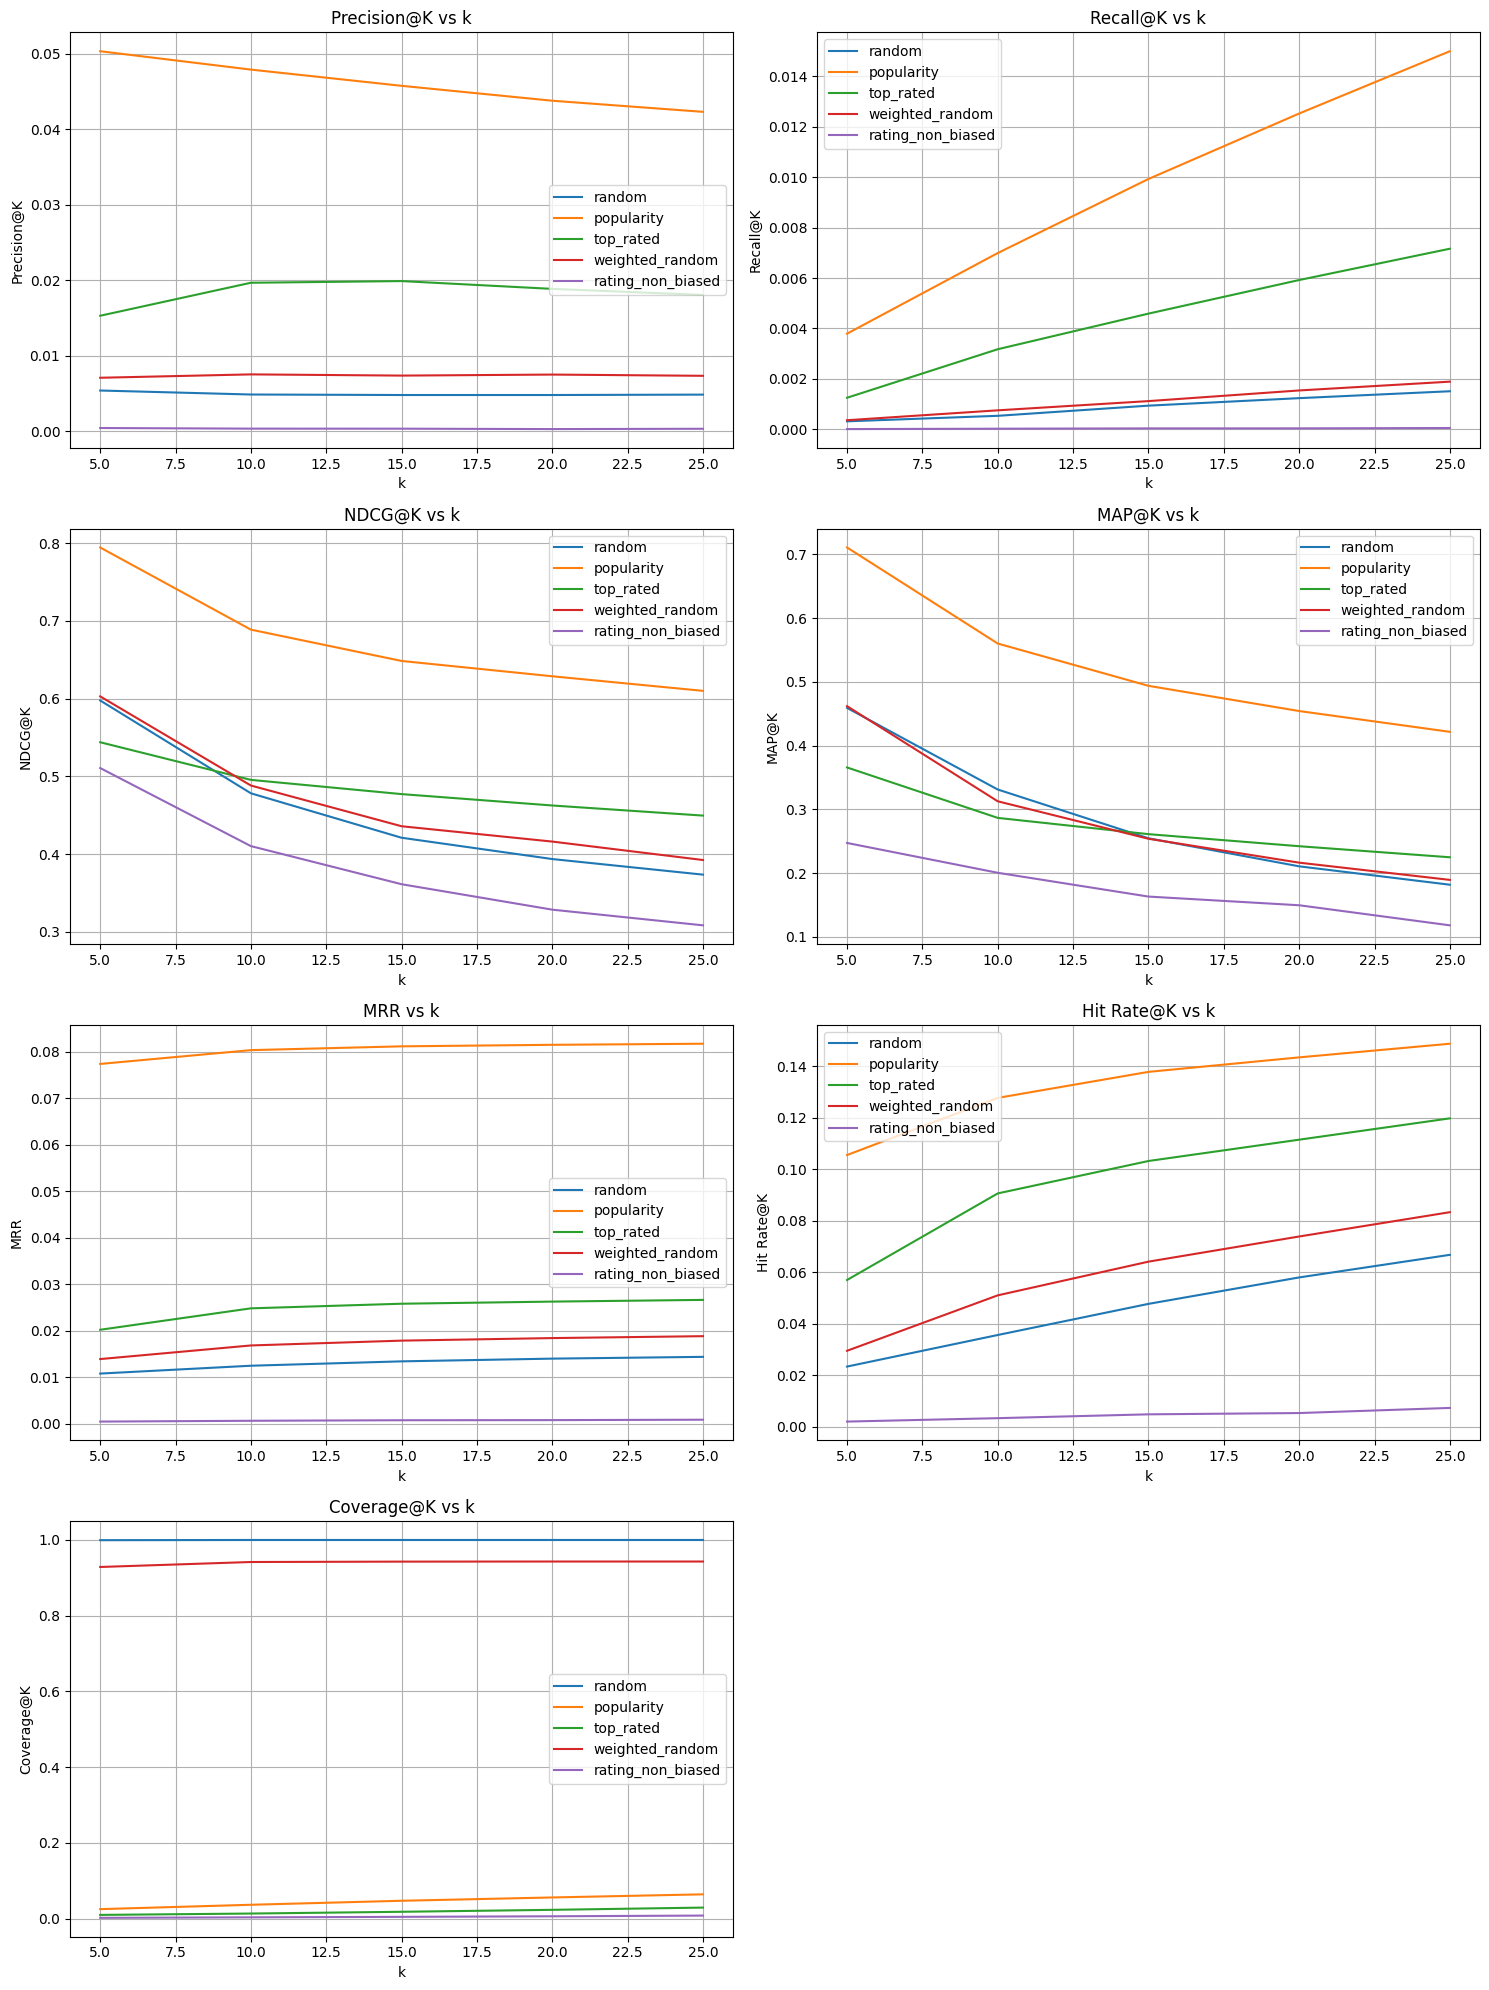

In [42]:

# Function to plot the metrics on a grid
def plot_metrics_grid(results, metrics):
    num_metrics = len(metrics)
    num_cols = 2  # Number of columns in the grid
    num_rows = (num_metrics + num_cols - 1) // num_cols  # Calculate rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten to easily iterate over them

    for idx, metric_name in enumerate(metrics):
        ax = axes[idx]
        for recommender in results:
            ks = sorted(results[recommender].keys())  # Sorting keys
            metric_values = [results[recommender][k][metric_name] for k in ks]
            ax.plot(ks, metric_values, label=recommender)
        
        ax.set_xlabel('k')
        ax.set_ylabel(metric_name)
        ax.set_title(f'{metric_name} vs k')
        ax.legend()
        ax.grid(True)

    # Hide any unused subplots
    for idx in range(len(metrics), len(axes)):
        fig.delaxes(axes[idx])
        
    plt.tight_layout()
    plt.show()

# List of metrics to plot
metrics = ['Precision@K', 'Recall@K', 'NDCG@K', 'MAP@K', 'MRR', 'Hit Rate@K', 'Coverage@K']

# Plot all metrics in a grid
plot_metrics_grid(results, metrics)


From the plots above we can make following conclusions: 

- Popularity recommender consistently outperforms other methods across most metrics, especially in Precision@K, Recall@K, NDCG@K, MAP@K, MRR, and Hit Rate@K. This indicates that it is the most effective recommender system in this comparison.
- Top_rated and weighted_random show moderate performance across all metrics, generally better than random and rating_non_biased.
- Random and rating_non_biased consistently underperform in most metrics, indicating they are less effective recommendation strategies.
- Coverage is highest for the random recommender , suggesting that it explores more items, while other recommenders, especially rating_non_biased, have lower coverage, focusing on a smaller set of items. This is expected, since for random recommender we pick almost all movies from our movie set, therefore we can even see that the coverage in this case is higher than 1, since we compare it to the test set with fewer movies.

## Additional 

We  can also check how these methods work on user-based split


In [43]:
test_user_ids = np.random.choice(ratings['user_id'].unique(), size=int(len(ratings['user_id'].unique())*0.2), replace=False)
train_ratings, test_ratings = ratings[~ratings['user_id'].isin(test_user_ids)], ratings[ratings['user_id'].isin(test_user_ids)]

user_mean = train_ratings.groupby('user_id')['rating'].mean().reset_index()
user_mean.columns = ['user_id', 'mean_rating']

train_ratings = pd.merge(train_ratings, user_mean, on='user_id')

train_ratings['rating_minus_mean'] = train_ratings['rating'] - train_ratings['mean_rating']


In [44]:
random_recommendations = get_random_recommendations(train_ratings,users,movies,k=5)
evaluate_recommender_system(random_recommendations, test_ratings,total_amount_of_movies, k=5)

{'Precision@K': 0.008145695364238412,
 'Recall@K': 0.0002608706591529713,
 'NDCG@K': 0.6142390707214835,
 'MAP@K': 0.4795859538784067,
 'MRR': 0.01711644591611479,
 'Hit Rate@K': 0.035099337748344374,
 'Coverage@K': 0.9997424671645635}

In [45]:
popularity_recommendations = get_popular_recommendations(train_ratings,users, movies, k=5)
evaluate_recommender_system(popularity_recommendations, test_ratings,total_amount_of_movies, k=5)

{'Precision@K': 0.09698675496688741,
 'Recall@K': 0.0050904360513103365,
 'NDCG@K': 0.8542374006761418,
 'MAP@K': 0.775630715862504,
 'MRR': 0.13846578366445914,
 'Hit Rate@K': 0.175,
 'Coverage@K': 0.03064640741694566}

In [46]:
rating_recommendations = get_top_rated_recommendations(train_ratings,users, movies, k=5)
evaluate_recommender_system(rating_recommendations, test_ratings,total_amount_of_movies, k=5)

{'Precision@K': 0.037284768211920526,
 'Recall@K': 0.0017147495927327281,
 'NDCG@K': 0.6092382185339131,
 'MAP@K': 0.41977407943399264,
 'MRR': 0.04767935982339956,
 'Hit Rate@K': 0.11440397350993377,
 'Coverage@K': 0.008756116404841618}

In [47]:
weighted_random_recommendations = get_weighted_random(train_ratings,users, movies, k=5)
evaluate_recommender_system(weighted_random_recommendations, test_ratings,total_amount_of_movies, k=5)

{'Precision@K': 0.011721854304635763,
 'Recall@K': 0.00036633097882578773,
 'NDCG@K': 0.6219959334432746,
 'MAP@K': 0.48456392973856205,
 'MRR': 0.02243101545253863,
 'Hit Rate@K': 0.045033112582781455,
 'Coverage@K': 0.9371619881534896}

In [48]:
recommendation_rating_non_biased = get_top_rated_recommendations_non_biased(train_ratings,users ,movies, k=5)
evaluate_recommender_system(recommendation_rating_non_biased, test_ratings,total_amount_of_movies, k=5)


{'Precision@K': 0.00023178807947019865,
 'Recall@K': 9.2584959331787e-06,
 'NDCG@K': 0.4871147797198479,
 'MAP@K': 0.35714285714285715,
 'MRR': 0.0004139072847682119,
 'Hit Rate@K': 0.0011589403973509935,
 'Coverage@K': 0.0018027298480556271}

Using user-based split we can observe the same picture as with temporal split, the popularity recommendation dominates here and top_rated and weighted_random show moderate performance here.